In [84]:
import dask.distributed
import dask.utils
import numpy as np
import planetary_computer as pc
import xarray as xr
from IPython.display import display
from pystac_client import Client
import geopandas as gpd
import requests
from pystac.extensions.eo import EOExtension as eo
from odc.stac import configure_rio, stac_load
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling
from rasterio.windows import Window
from rasterio.plot import reshape_as_image, reshape_as_raster, show
from rasterio.features import geometry_mask, geometry_window
from contextlib import contextmanager  

import cv2
from segment_anything import SamPredictor, SamAutomaticMaskGenerator,sam_model_registry

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import torch

In [85]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, client=client)
display(client)

/home/laserglaciers/miniconda3/envs/py310v2/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41169 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41169/status,
Dashboard: http://127.0.0.1:41169/status,Workers: 4
Total threads: 12,Total memory: 15.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39945,Workers: 4
Dashboard: http://127.0.0.1:41169/status,Total threads: 12
Started: Just now,Total memory: 15.45 GiB
Comm: tcp://127.0.0.1:40039,Total threads: 3
Dashboard: http://127.0.0.1:44393/status,Memory: 3.86 GiB
Nanny: tcp://127.0.0.1:35519,


In [86]:
resolution = 10

In [59]:
import pickle
with open('../src/stac_items/helheim_stac_items.pkl', 'wb') as f:
    pickle.dump(selected_items, f)

In [60]:
selected_items

[<Item id=S2A_MSIL2A_20230727T142031_R096_T24WWU_20230727T223047>,
 <Item id=S2A_MSIL2A_20200903T142941_R139_T24WWU_20201027T151835>,
 <Item id=S2A_MSIL2A_20180504T141951_R096_T24WWU_20201012T054158>,
 <Item id=S2B_MSIL2A_20240822T140729_R053_T24WWU_20240822T195417>,
 <Item id=S2A_MSIL2A_20160424T142002_R096_T24WWU_20210211T060552>]

In [76]:
helheim_datacube = stac_load(
    selected_items,
    bands=["red", "green", "blue", "nir"],
    resolution=resolution,
    chunks={"x": 2048, "y": 2048},
    patch_url=pc.sign,
    # force dtype and nodata
    dtype="uint16",
    nodata=0,
    geopolygon=hel_mel
)

In [77]:
def to_float(datacube):
    _datacube = datacube.astype("float32")
    nodata = _datacube.attrs.pop("nodata", None)
    if nodata is None:
        return _datacube
    return _datacube.where(datacube != nodata)


def colorize(datacube, colormap):
    return xr.DataArray(colormap[datacube.data], coords=datacube.coords, dims=(*datacube.dims, "band"))

In [94]:
time=3
rgb = np.dstack((helheim_datacube.red.isel(time=time).values,
                 helheim_datacube.green.isel(time=time).values,
                 helheim_datacube.blue.isel(time=time).values))
# Normalize the RGB data
rgb_norm = rgb / rgb.max()

# # Display the normalized RGB image using plt.imshow
# plt.imshow(rgb_norm)

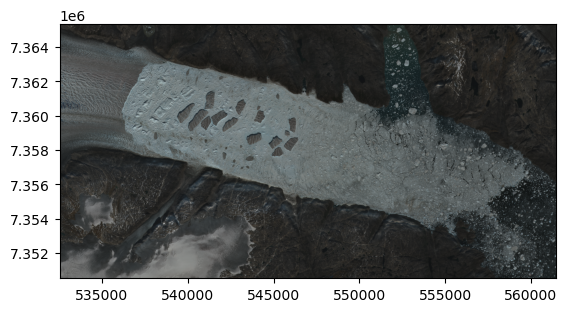

<Axes: >

In [80]:
affine = xx.red.isel(time=time).odc.affine

#better for rasterio?
helheim_raster = reshape_as_raster(rgb_norm)
show(helheim_raster, transform=affine)

In [81]:
height, width = helheim_datacube.red.isel(time=time).shape

In [87]:
#https://rasterio.groups.io/g/main/topic/memoryfile_workflow_should/32634761
@contextmanager
def mem_raster(data, **profile):
    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset_writer:
            dataset_writer.write(data)
 
        with memfile.open() as dataset_reader:
            yield dataset_reader

def cv2Norm(band):
    img_u8 = cv2.normalize(band, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    return img_u8

profile_t = {'driver':'GTiff', 'count':3, 
                      'transform':affine, 'crs':32624, 
                      'width':t.shape[2], 'height': t.shape[1], 
                      'dtype':np.float64
}

In [90]:
def sam_segment(image_chunk, feature_of_interest = 'icebergs', model_type = 'vit_h',
                model_weights='sam_vit_h_4b8939.pth', gpu=False):
    #icebergs,crevasse,terminus,supraglacial_lakes,planet, sentinel-2, sentinel-1, timelapse
    # MODEL_TYPE = 'vit_h'
    # MODEL_WEIGHTS = 'sam_vit_h_4b8939.pth' # sam_vit_b_01ec64.pth,sam_vit_h_4b8939.pth,sam_vit_l_0b3195.pth

    sam = sam_model_registry[f"{model_type}"](checkpoint=f"../src/sam_models/{model_weights}")

    if gpu = True:
        if torch.cuda.is_available():
            sam.to(device='cuda')
            
    predictor = SamPredictor(sam)
    predictor.set_image(image_chunk)

    mask_generator = SamAutomaticMaskGenerator(sam)
    masks = mask_generator.generate(image_chunk)
    if feature_of_interest == 'terminus':
        for num in range(len(masks)):
            im = Image.fromarray(masks[num]['segmentation'])
    else:
        binary_pred_zeros = np.zeros_like(masks[1]['segmentation'])
        for num in range(len(masks)):
            # 25% or higher number of pixels are True, that means it is a potential representation of background
            # and not of icebergs
            if np.count_nonzero(masks[num]['segmentation'])>(0.25*(masks[num]['segmentation']).size):
                continue
            else:               
                binary_pred_zeros[masks[num]['segmentation']==1]=1
        im = Image.fromarray(binary_pred_zeros)


    
    return im

In [91]:
grid_path = '../src/grid/melange_box_grid_utm24.gpkg'
grid = gpd.read_file(grid_path)
image_chunk_dict = {}
date = str(xx.red.isel(time=time).time.dt.date.data)

with mem_raster(t, **profile_t) as ds:
    for i, geom in enumerate([grid2.iloc[1].geometry]): 
        window = geometry_window(ds, [geom])
        w = ds.read([1,2,3], window=window)
        win_transform = ds.window_transform(window)
        w2 = np.moveaxis(w,0,-1)
        # show(w,transform=win_transform)
        image_chunk_dict[win_transform] = w
        im = sam_segment(w2)
        
        nim = np.array(im)
        profile_out = {'driver':'GTiff', 'count':1, 
                      'transform':win_transform, 'crs':32624, 
                      'width':nim.shape[1], 'height': nim.shape[0], 
                      'dtype':np.float64
                        }
        # out_name = f'{date}_helheim_{i}.tif'
        # with rasterio.open(f'/media/laserglaciers/upernavik/iceberg_py/outfiles/helheim/sam_output/{out_name}', mode='w', **profile_out) as dst:
        #     dst.write(nim,1)

/home/laserglaciers/miniconda3/envs/py310v2/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

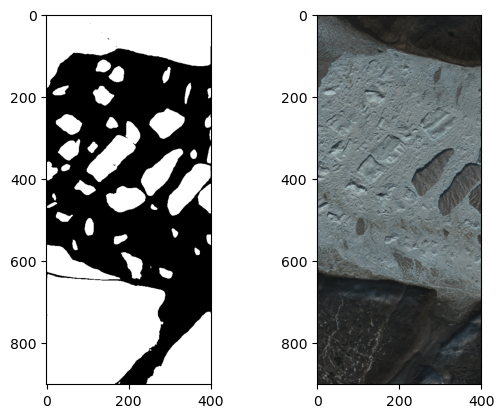

In [92]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(im)
ax[1].imshow(w2)

In [93]:
torch.cuda.is_available()

False